In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.kernel_ridge import KernelRidge 
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone 
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error #均方误差
import xgboost as xgb #XGBoost

In [3]:
#loading data
data_train = pd.read_csv("C:/Users/sahar/Desktop/Sahar/Master of Data Science/Spring 2019 Semester/Data Mining/Project/train.csv")

data_test = pd.read_csv("C:/Users/sahar/Desktop/Sahar/Master of Data Science/Spring 2019 Semester/Data Mining/Project/test.csv")

In [4]:
#data preprocessing

data_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


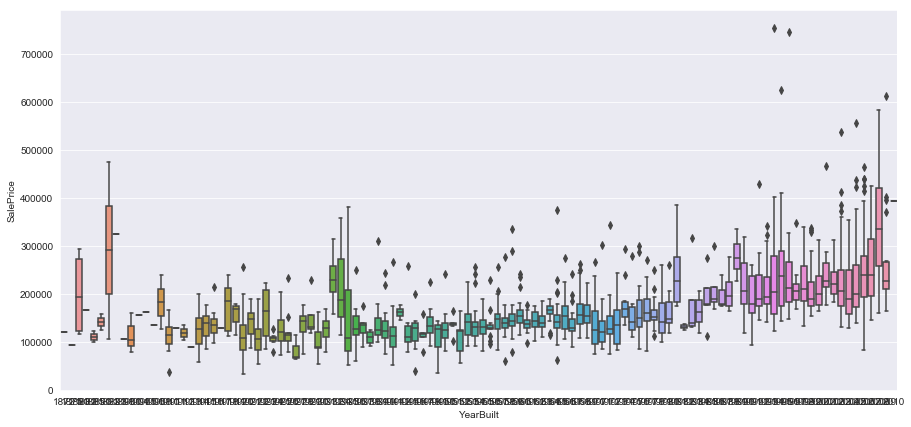

In [5]:
#Exploratory Visualization
#try to plot the relationship between 'YearBuilt' and 'SalePrice'

plt.figure(figsize=(15,7))
sns.boxplot(data_train.YearBuilt, data_train.SalePrice)

#As we can see below, it has a trend that the house built lately is more expensive than the house built years ago

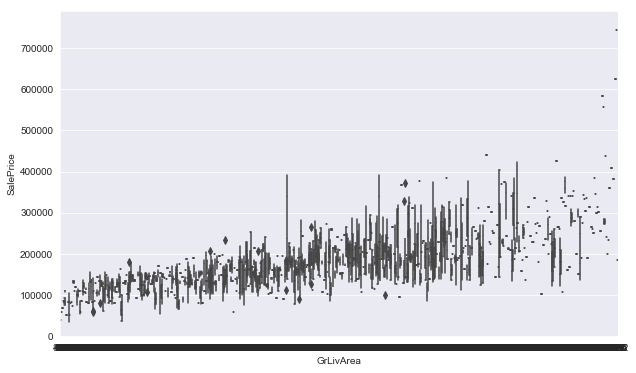

In [6]:
#try to plot the relationship between 'GrLivArea' and 'SalePrice'

plt.figure(figsize=(10,6))
sns.boxplot(data_train.GrLivArea, data_train.SalePrice)

#As we can see below, the house with more living area tends to be more expensive than the house with less living area.

In [7]:
#select the column 'id' seperate from others for the convenience of the following operation.

train_id = data_train['Id']
data_train.drop("Id", axis = 1, inplace = True)
test_ID = data_test['Id']
data_test.drop("Id", axis = 1, inplace = True)

Text(0.5, 0, 'GrLivArea')

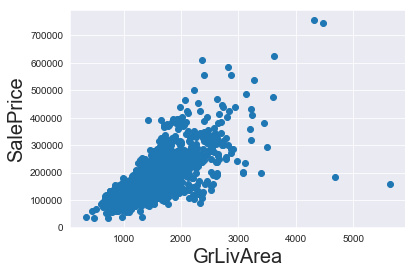

In [8]:
#Exploratory visualization for outlier

fig, ax = plt.subplots()
ax.scatter(x = data_train['GrLivArea'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=20)
plt.xlabel('GrLivArea', fontsize=20)

Text(0.5, 0, 'GrLivArea')

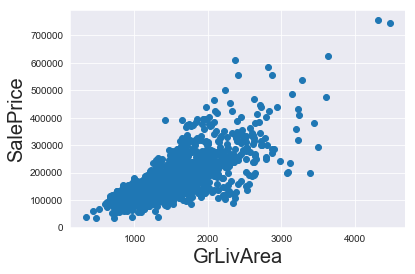

In [9]:
#from above we can obviously see there are two outlier, whhich are > 4000. Therefore, we need to delete it.

data_train = data_train.drop(data_train[(data_train['GrLivArea']>4000) & (data_train['SalePrice']<300000)].index)

#regraphic to check if we delete those two points. 
fig, ax = plt.subplots()
ax.scatter(x = data_train['GrLivArea'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=20)
plt.xlabel('GrLivArea', fontsize=20)

In [10]:
#Since 'SalePrice' is our target attribute, we need to do some analysis on it firstly.

data_train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.881296
Kurtosis: 6.523067


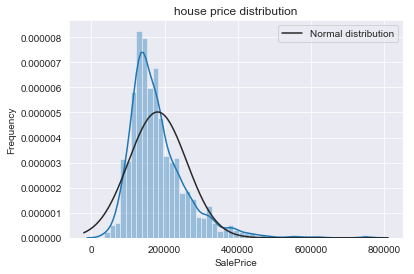

In [11]:
#check for normal distribution

sns.distplot(data_train['SalePrice'],fit=norm)
plt.ylabel('Frequency')
plt.legend(['Normal distribution'], loc='best')
plt.title('house price distribution')
print("Skewness: %f" % data_train['SalePrice'].skew())
print("Kurtosis: %f" % data_train['SalePrice'].kurt())

Skewness: 0.121580
Kurtosis: 0.804751


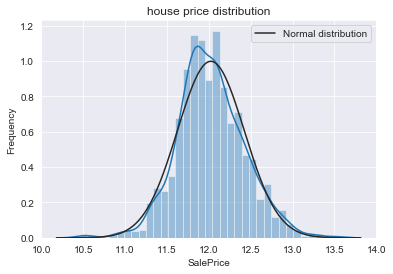

In [12]:
#from what we have get above, we know that the data set is peakedness and positive skew.
#Therefore, we need to make use of log function in order to transfer the data set into normal distribution
#So that we can use linear regression model to fit the data.

#for the log function, log(x), x cannot be 0, so we use log1p, which equals to log(x+1).
data_train['SalePrice'] = np.log1p(data_train['SalePrice'])
sns.distplot(data_train['SalePrice'],fit=norm)
plt.ylabel('Frequency')
plt.legend(['Normal distribution'], loc='best')
plt.title('house price distribution')
print("Skewness: %f" % data_train['SalePrice'].skew())
print("Kurtosis: %f" % data_train['SalePrice'].kurt())

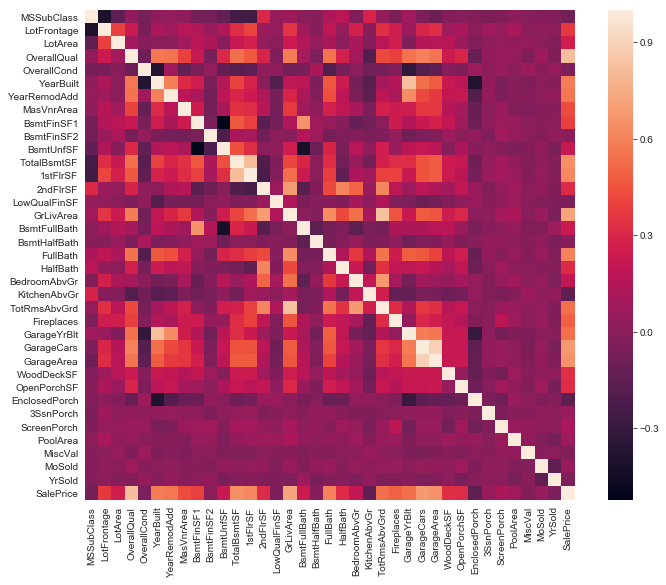

In [13]:
# Feature selection
# First, we use corrlation matrix to see correlation betwee features and SalePrice

corrmap = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmap, vmax=1, square=True)

#From what we have observed, the features that are strongly correlated with SalePrice are the following:
# OverallQual, YearBuilt, TotalBsmtSF, 1stFlrSF, GrLiveArea, FullBath, TotRmsAbvGrd, GarageCars, GarageArea


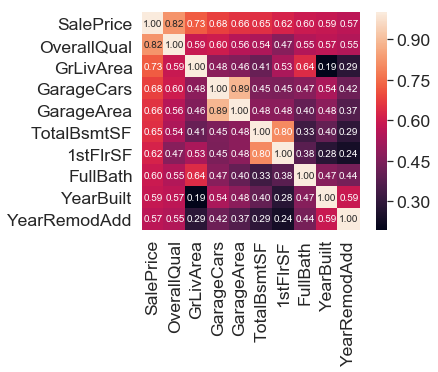

In [14]:
#However, what we have get from above is very objective, so we decide to make the corrmap more clear

k  = 10 # we just want 10 features to show
cols = corrmap.nlargest(k, 'SalePrice')['SalePrice'].index #sorted by the 10 largest values of columns
cm = np.corrcoef(data_train[cols].values.T) #transpose
sns.set(font_scale=1.6)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#From the heatmap, we can clearly see that OverallQual, GrLiveArea,  GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, YearBuilt, YearRemodAdd are highly correlated with SalePrice
#Since 'GarageCars' and 'GarageArea' basically are the sameconcepts, we keep 'Garagecars' as feature and drop 'GarageArea'


In [15]:
#check if there are any missing value between train data and test data.
#We first combine train data and test data and seperate 'SalePrice' from other attributes because it is our target variable.

ntrain = data_train.shape[0]
ntest = data_test.shape[0]
y_train = data_train.SalePrice.values
all_data = pd.concat((data_train, data_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

#check for missing values
null_count = all_data.isnull().sum().sort_values(ascending=False)
null_rate = null_count / len(all_data)
null_data = pd.concat([null_count,null_rate],axis=1,keys=['count','ratio'])
null_data.head(35)   #There are 34 attributes have missing values.


all_data size is : (2917, 79)


,count,ratio
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


In [16]:
### compute missing values with 'None' and '0'

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'MasVnrType','MSSubClass','MSZoning', 'Utilities','Functional',
            'KitchenQual','PoolQC','MiscFeature', 'Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    

for col in ('BsmtFullBath', 'BsmtHalfBath','GarageYrBlt','MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)



In [71]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))


In [72]:
#Since the variables below just have a few missing values, we use mode to fill the missing values

for col in ('Electrical', 'Exterior2nd','Exterior1st','SaleType','GarageCars','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','GarageCars','TotalBsmtSF','GarageArea'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])


In [73]:
#check if there still any missing value

null_count = all_data.isnull().sum().sort_values(ascending=False)
null_rate = null_count / len(all_data)
null_data = pd.concat([null_count,null_rate],axis=1,keys=['count','ratio'])
null_data.head(5)   #There is no missing values anymore.

,count,ratio
YrSold,0,0.0
Foundation,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0


In [74]:
#Then we need to transfer data type
#transforming numerical variables that actually are categorical

all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


# encoding categorical variables into numerical variables

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir')

for c in cols:
    le = LabelEncoder()
    le.fit(list(all_data[c].values))
    all_data[c] = le.transform(list(all_data[c].values))



In [75]:
all_data.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,...,WD,0,1,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,WD,0,1,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,WD,0,1,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,...,WD,0,1,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,WD,0,1,9,1145.0,AllPub,192,2000,2000,2008


In [76]:
#filter all numeric variables by index

numeric = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_var = all_data[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew = pd.DataFrame({'Skew' :skewed_var})
skew.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [77]:
#use box-cox to do data transformation

skew = skew[abs(skew) > 0.80]
print("There are {} features to be transformed".format(skew.shape[0]))

for var in skew.index:
    all_data[var] = boxcox1p(all_data[var], 0.15)
    


There are 53 features to be transformed


In [78]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 270)


In [79]:
#Seperate all_data into train and test data

train = all_data[:ntrain]
test = all_data[ntrain:]

train.head(5)

X_train=train

y=data_train.SalePrice



In [80]:
# Modeling and evaluation

In [81]:
#define loss fuction
n_folds = 5

def rmsle_cv(model):
    rmsle= np.sqrt(-cross_val_score(model, X_train, y, 
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmsle)

In [82]:
# Lasso
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#parameter tuning for lasso model
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
model_lasso.fit(X_train, y_train)
alpha = model_lasso.alpha_
alpha #0.005

0.0005

In [83]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Lasso score: 0.1131 (0.0071)



In [84]:
from sklearn import metrics
import os
from scipy.stats.stats import pearsonr

#check for lasso regression coefficient
coef = pd.Series(model_lasso.coef_, index = X_train.columns)   
  
print("Lasso model selects " + str(sum(coef != 0)) + 
      " variables and eliminates other " +  
      str(sum(coef == 0)) + " variables")    



Lasso model selects 118 variables and eliminates other 152 variables


In [85]:
coef

1stFlrSF                 0.012274
2ndFlrSF                -0.004510
3SsnPorch                0.001746
Alley                    0.020792
BedroomAbvGr            -0.017930
BsmtCond                 0.013301
BsmtExposure            -0.006999
BsmtFinSF1               0.005296
BsmtFinSF2              -0.001721
BsmtFinType1            -0.000980
BsmtFinType2            -0.005581
BsmtFullBath             0.030539
BsmtHalfBath             0.000000
BsmtQual                -0.038360
BsmtUnfSF               -0.003289
CentralAir               0.100016
EnclosedPorch            0.001021
ExterCond                0.023955
ExterQual               -0.037812
Fence                    0.000000
FireplaceQu             -0.000000
Fireplaces               0.030492
FullBath                 0.070128
Functional               0.070584
GarageArea               0.013901
GarageCars               0.065961
GarageCond               0.017458
GarageFinish            -0.007519
GarageQual               0.000000
GarageYrBlt   

Text(0.5,1,'Coefficients for Lasso Model')

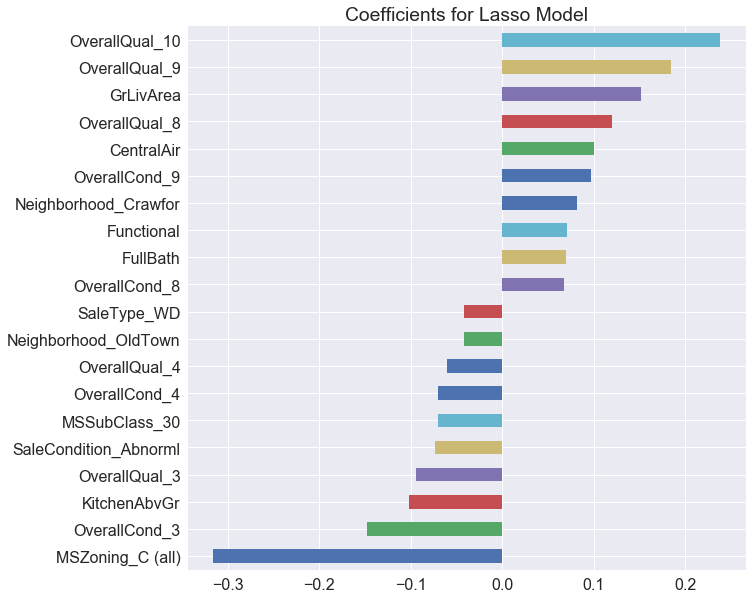

In [86]:
import matplotlib.pyplot as plt
import matplotlib

#check for the importance of each feature

important_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (10, 10)
important_coef.plot(kind = "barh")
plt.title("Coefficients for Lasso Model")

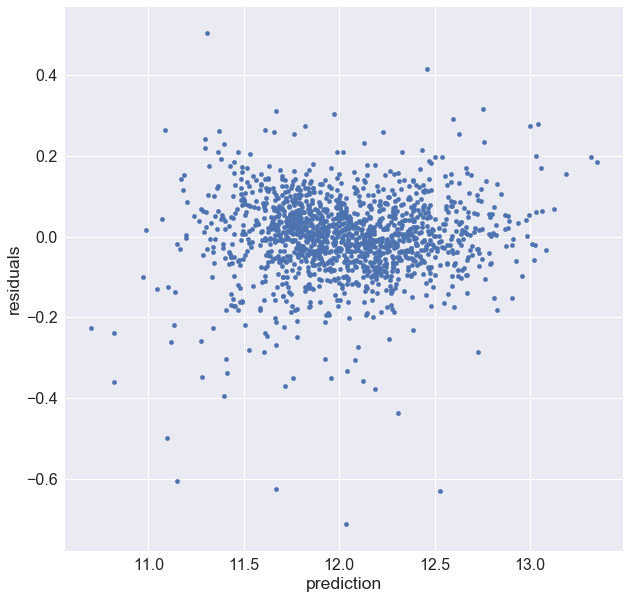

In [87]:
#residuals for lasso:
matplotlib.rcParams['figure.figsize'] = (10, 10)

preds = pd.DataFrame({"prediction":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["prediction"]
preds.plot(x = "prediction", y = "residuals",kind = "scatter")

In [88]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor 

#use grad-search to do parameter tuning for GradientBoostingRegressor

model=GradientBoostingRegressor(n_estimators=500,learning_rate=0.3)
param_grid={'n_estimators':[500,1000],'learning_rate':[0.05,0.2]}
grid_search=GridSearchCV(model,param_grid,n_jobs=1,verbose=1)
grid_search.fit(X_train, y_train)
best_parameters= grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   59.2s finished


{'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


In [89]:
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=1, min_samples_split=2)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Gradient Boosting score: 0.1166 (0.0084)



In [90]:
model=xgb.XGBRegressor(colsample_bytree=0.5)
param_grid={'colsample_bytree':[0.2,0.5]}
grid_search=GridSearchCV(model,param_grid,n_jobs=1,verbose=1)
grid_search.fit(X_train, y_train)
best_parameters= grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.4s finished


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.2, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


In [91]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0,colsample_bylevel=1,
                             learning_rate =0.1,max_depth=3,importance_type='gain',
                             min_child_weight=1, n_estimators=100,
                             reg_lambda=1,scale_pos_weight= 1,
                             subsample=1,silent=True)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1273 (0.0065)



In [92]:
#plot the importance of features for xgb

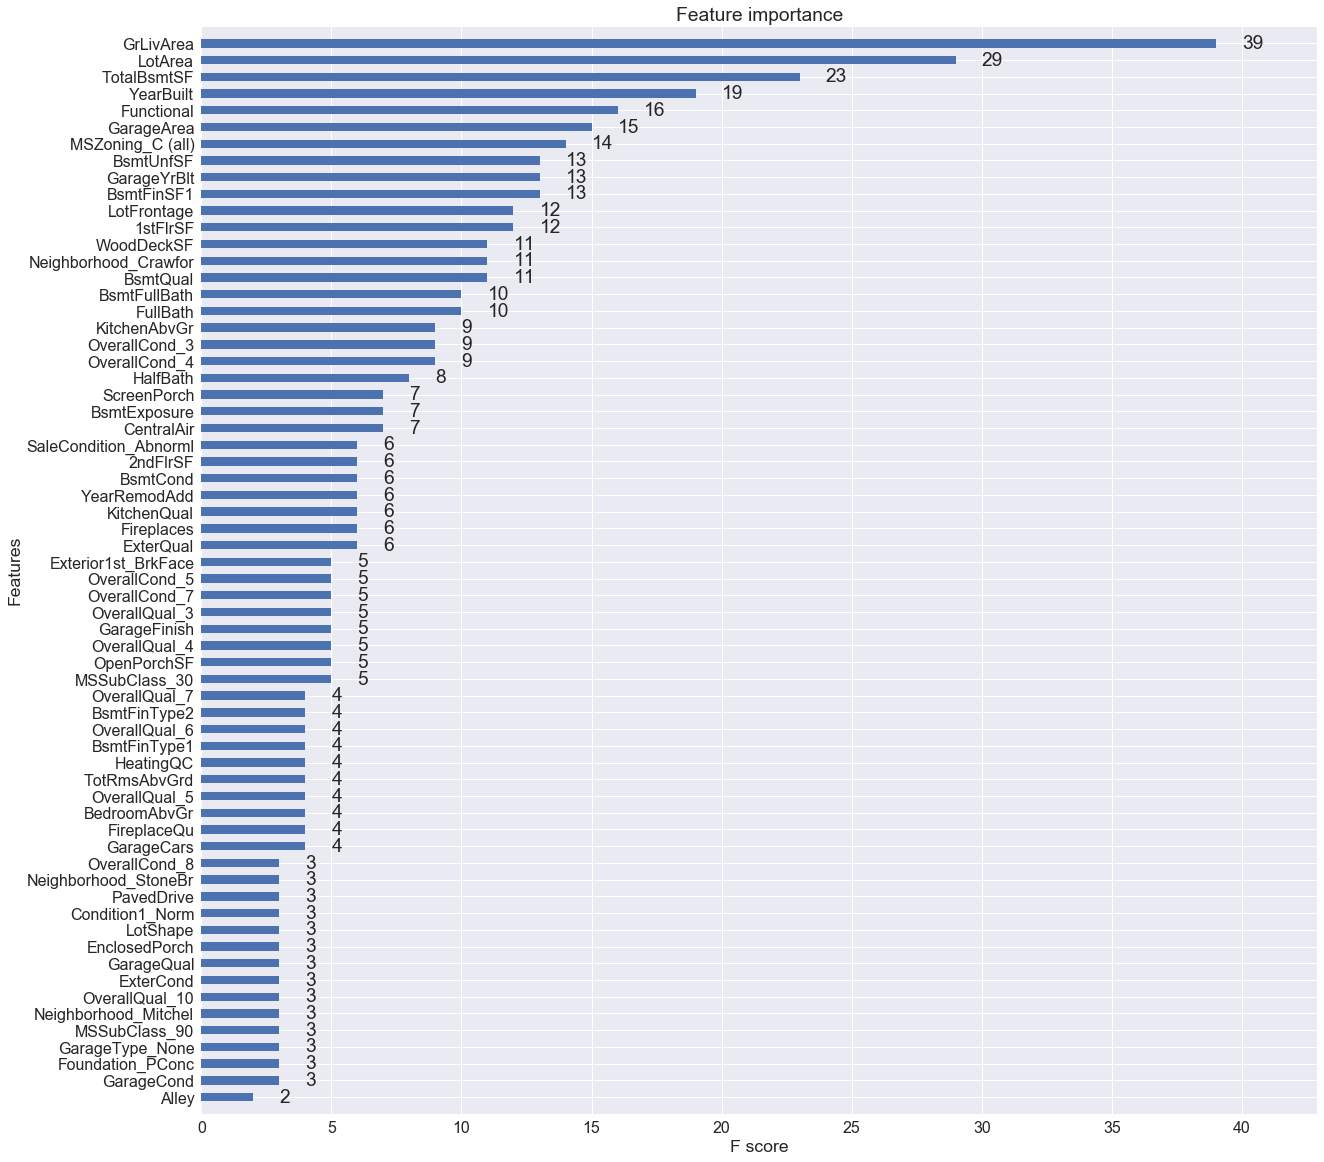

In [93]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

model_xgb.fit(X_train, y)

fig,ax = plt.subplots(figsize=(20,20))
plot_importance(model_xgb,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()



In [94]:
#KRR
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
alpha


0.6

In [95]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1163 (0.0056)



In [96]:
#check for krr regression coefficient
coef = pd.Series(ridge.coef_, index = X_train.columns)   
  
print("KRR model selects " + str(sum(coef != 0)) + 
      " variables and eliminates other " +  
      str(sum(coef == 0)) + " variables")    



KRR model selects 267 variables and eliminates other 3 variables


In [97]:
coef

1stFlrSF                 0.009715
2ndFlrSF                -0.001956
3SsnPorch                0.002949
Alley                    0.026368
BedroomAbvGr            -0.022853
BsmtCond                 0.014327
BsmtExposure            -0.004257
BsmtFinSF1               0.004877
BsmtFinSF2              -0.002071
BsmtFinType1             0.000411
BsmtFinType2            -0.011790
BsmtFullBath             0.041897
BsmtHalfBath             0.018710
BsmtQual                -0.025664
BsmtUnfSF               -0.002957
CentralAir               0.076550
EnclosedPorch            0.002133
ExterCond                0.022976
ExterQual               -0.017393
Fence                    0.004752
FireplaceQu              0.001321
Fireplaces               0.029997
FullBath                 0.085502
Functional               0.056542
GarageArea               0.012378
GarageCars               0.069307
GarageCond               0.014579
GarageFinish            -0.004420
GarageQual              -0.003247
GarageYrBlt   

Text(0.5,1,'Coefficients for krr Model')

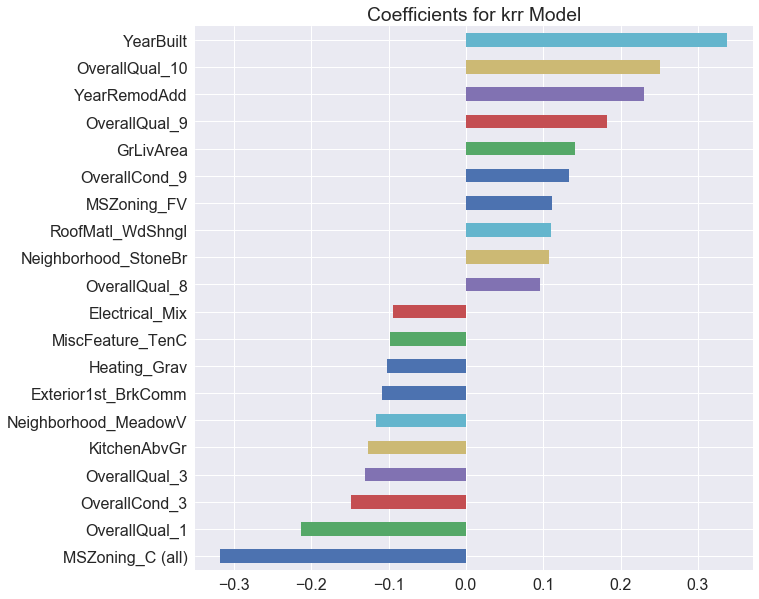

In [98]:
#check for the importance of each feature

important_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (10, 10)
important_coef.plot(kind = "barh")
plt.title("Coefficients for krr Model")

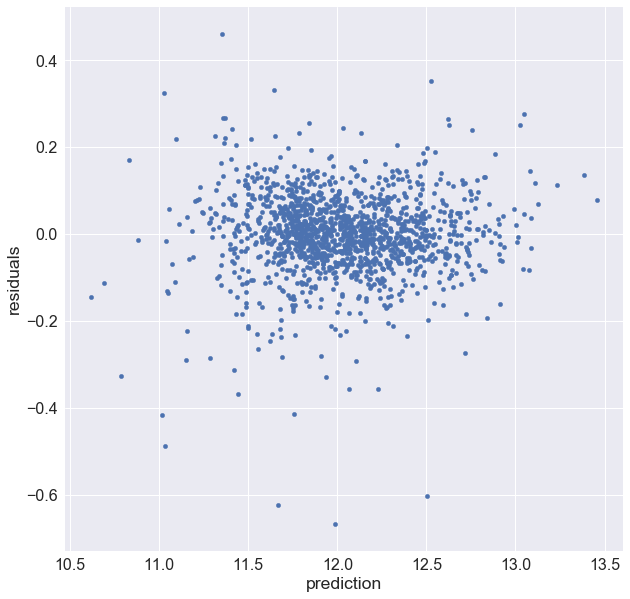

In [99]:
#residuals for krr:
matplotlib.rcParams['figure.figsize'] = (10, 10)

preds = pd.DataFrame({"prediction":ridge.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["prediction"]
preds.plot(x = "prediction", y = "residuals",kind = "scatter")

In [100]:
# simple stacking


class Averagemodel(BaseEstimator, RegressorMixin):
    def __init__(self,mod):
        self.mod = mod

        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) \
        for model in self.models_])
        return np.mean(predictions, axis=1)
    

In [101]:

avg = Averagemodel(mod = (lasso,GBoost,model_xgb,KRR))
score = rmsle_cv(avg)
print(score.mean())         

0.1111944751498588


In [102]:
avg = Averagemodel(mod = (lasso,GBoost,KRR))
score = rmsle_cv(avg)
print(score.mean())        

0.11037383725559924


In [103]:
avg = Averagemodel(mod = (lasso,GBoost))
score = rmsle_cv(avg)
print(score.mean())        

0.11103032888779558


In [104]:
stack_model = Averagemodel(mod = (lasso,GBoost,KRR))
stack_model.fit(X_train, y_train)
pred = np.exp(stack_model.predict(test))
pred

result=pd.DataFrame({'Id':test_ID,'SalePrice':pred})
result

,Id,SalePrice
0,1461,120814.785951
1,1462,162559.061866
2,1463,187539.584364
3,1464,198742.874816
4,1465,199888.737551
5,1466,174290.334401
6,1467,181800.087166
7,1468,162257.181878
8,1469,181599.780303
9,1470,123520.182336
